In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread, imsave
from scipy.io import loadmat
import os
from skimage.segmentation import slic
from sklearn.cluster import spectral_clustering
from skimage.color import rgb2lab, rgb2hsv
from skimage.exposure import rescale_intensity
%matplotlib inline

images_folder_path = './BSR/BSDS500/data/images/'
gt_folder_path = './BSR/BSDS500/data/groundTruth/'

In [2]:
images_paths = sorted(glob(f'{images_folder_path}train/*.jpg'))
gt_paths = sorted(glob(f'{gt_folder_path}train/*.mat'))

images = [imread(path) / 255.0 for path in images_paths]
# gts = [loadmat(path)['groundTruth'][0][0][0][0][0] for path in gt_paths]
gts = []
for path in gt_paths:
    mat_file = loadmat(path)['groundTruth']
    gt_list = [mat_file[0][i][0][0][0] for i in range(len(mat_file[0]))]
    gts.append(gt_list)

In [3]:
def my_kmeans(img, k, max_iter=50, tol=0.1, use_space=False):
    if use_space:
        x = np.linspace(0, 1, img.shape[0])
        y = np.linspace(0, 1, img.shape[1])
        xx, yy = np.meshgrid(x, y, indexing='ij')
        img = np.dstack((img, xx, yy))

    shape = img.shape
    img = img.reshape(-1, img.shape[-1])
    centers = img[ np.random.choice(img.shape[0], k, False) ]

    for _ in range(max_iter):
        dist = np.linalg.norm(img[:, None, :] - centers, axis=2)
        assignment = np.argmin(dist, axis=1)

        if k != len(np.unique(assignment)):
            centers = img[ np.random.choice(img.shape[0], k, False) ]
            continue
        new_centers = []

        for i in range(k):
            new_centers.append(img[assignment == i].mean(axis=0))
        
        new_centers = np.array(new_centers)

        if np.linalg.norm(new_centers - centers, axis=1).mean() < tol:
            break
        centers = new_centers
    assignment = assignment.reshape(shape[:-1])
    return assignment

In [4]:
# from sklearn.feature_extraction import img_to_graph
# from scipy.sparse import *
# # clf = KMeans(5)

# def knn_dist_mem(img, k):
#     depth = img.shape[-1]
#     img = img.reshape(-1, depth)
#     n = img.shape[0]
#     nearset_mat = csr_matrix((n, n), dtype=np.bool)
#     for i, pixel in enumerate(img):
#         dist_mat = np.linalg.norm(img - pixel, axis=1)
#         inds = np.argpartition(dist_mat, k+1)[:k+1]
#         nearset_mat[i, inds] = True
#     nearset_mat.setdiag(False)
#     return nearset_mat


# def knn_dist(img, k):
#     depth = img.shape[-1]
#     img = img.reshape(-1, depth)
#     dist_mat = np.linalg.norm(img[:, None, ...] - img, axis=2)
#     nearset_mat = np.zeros_like(dist_mat)
#     inds = np.argpartition(dist_mat, k+1, axis=1)[:, :k+1]
#     nearset_mat[np.arange(len(dist_mat)).reshape(-1, 1), inds] = 1
#     np.fill_diagonal(nearset_mat, 0)
#     return img_to_graph(nearset_mat)


# clf = SpectralClustering(5)
# img = images[0]
# x = np.linspace(0, 2, img.shape[0])
# y = np.linspace(0, 2, img.shape[1])
# xx, yy = np.meshgrid(x, y, indexing='ij')
# new_img = np.dstack((img, xx, yy))
# new_img = knn_dist_mem(new_img, 5)
# labels = clf.fit_predict(new_img)
# plt.subplot(131)
# plt.imshow(img)
# plt.subplot(132)
# plt.imshow(labels.reshape(img.shape[:2]))
# plt.subplot(133)
# plt.imshow(gts[0])

In [5]:
def get_contingency_table(pred, gt):
    clusters = np.arange(pred.max() + 1)
    r = pred.max() + 1
    k = gt.max() + 1
    mat = np.zeros((r, k))
    for cluster in clusters:
        points = gt[pred == cluster]
        vals, counts = np.unique(points, return_counts=True)
        mat[cluster, vals] += counts
    return mat

def get_f_measure(pred, gt):
    mat = get_contingency_table(pred, gt)
    prec = mat.max(axis=1) / mat.sum(axis=1)
    recall = mat.max(axis=1) / np.array([np.unique(gt[pred == label], return_counts=True)[1].max() for label in range(pred.max()+1)])
    f = 2 * prec * recall / (prec + recall)
    return f.sum() / len(mat)

# def conditinal_entropy(pred, gt):
#     mat = get_contingency_table(pred, gt)
#     size_per_cluster = mat.sum(axis=1)
#     mat_normalized = mat / size_per_cluster.reshape(-1, 1)
#     print(mat_normalized)
#     entropy_per_cluster = np.sum(mat_normalized * np.log(mat_normalized), axis=1)
#     return np.sum(entropy_per_cluster * size_per_cluster / mat.sum())

def conditinal_entropy(pred, gt):
    clusters, cluster_sizes = np.unique(pred, return_counts=True)
    
    clusters_entropy = []
    for cluster in clusters:
        cluster_points = gt[pred == cluster]
        classes_counts = np.unique(cluster_points, return_counts=True)[1] / len(cluster_points)
        clusters_entropy.append((-classes_counts * np.log(classes_counts)).sum())
    clusters_entropy = np.array(clusters_entropy)
    return (cluster_sizes / len(gt) * clusters_entropy).sum()

def get_img_name(img_path):
    return os.path.basename(img_path).split('.')[0]

In [6]:
from skimage.color import rgb2hsv, rgb2lab
from skimage.exposure import rescale_intensity
from skimage.filters import gaussian

f_measure_array = []
entropy_array = []

for img_display, img_path, img_gts in zip(images, images_paths, gts):
    img_name = os.path.basename(img_path).split('.')[0]
    img = img_display
    # img = rgb2lab(gaussian(images[i], multichannel=False))
    # img = rescale_intensity(img)
    # labels = clf.fit_predict(features.reshape(-1, features.shape[-1]))
    image_f_measure = []
    image_entropy = []
    for k in [3, 5, 7, 9, 11]:
        labels = my_kmeans(img, k)
        imsave(f'output/{img_name}_{k}.png', labels.astype(np.uint8), check_contrast=False)
        flattened_labels = labels.flatten()
        
        f_measure_for_k = [get_f_measure(flattened_labels, gt.reshape(-1)) for gt in img_gts]
        entropy_score_for_k = [conditinal_entropy(flattened_labels, gt.reshape(-1)) for gt in img_gts]

        image_f_measure.append(f_measure_for_k)
        image_entropy.append(entropy_score_for_k)

    f_measure_array.append(image_f_measure)
    entropy_array.append(image_entropy)

    # plt.figure(figsize=(15, 10))
    # plt.subplot(131)
    # plt.imshow(img_display)
    # plt.subplot(132)
    # plt.imshow(labels)
    # plt.subplot(133)
    # plt.imshow(gts[i][0])
    # plt.show()

In [7]:
f_measure_average_per_k = []
for img in f_measure_array:
    f_measure_average_per_k.append([np.mean(k_array) for k_array in img])
f_measure_average_per_k = np.array(f_measure_average_per_k)

entropy_average_per_k = []
for img in entropy_array:
    entropy_average_per_k.append([np.mean(k_array) for k_array in img])
entropy_average_per_k = np.array(entropy_average_per_k)

In [13]:
sorted_scores = np.argsort(np.mean(f_measure_average_per_k, axis=1))

## Bad Clustering Example

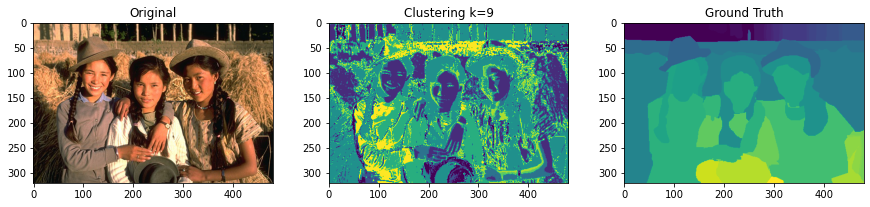

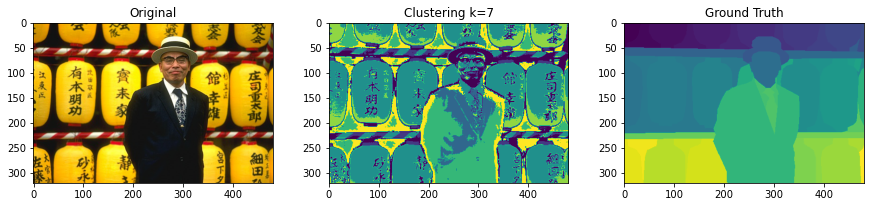

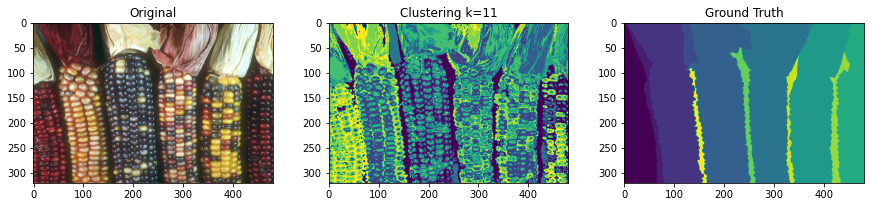

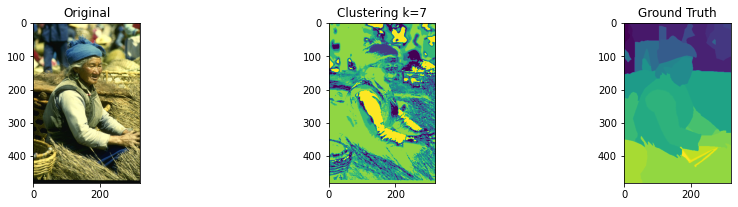

In [20]:
# Bad example
for i in range(4):
    img_index = sorted_scores[i]
    img_k = np.argmax(f_measure_average_per_k[img_index]) * 2 + 3
    clustering_path = f'output/{get_img_name(images_paths[img_index])}_{img_k}.png'

    plt.figure(figsize=(15, 10))
    plt.subplot(331)
    plt.title('Original')
    plt.imshow(images[img_index])
    plt.subplot(332)
    plt.title(f'Clustering k={img_k}')
    plt.imshow(imread(clustering_path))
    plt.subplot(333)
    plt.title('Ground Truth')
    plt.imshow(gts[img_index][0])
    plt.show()

## Good Clustering Example

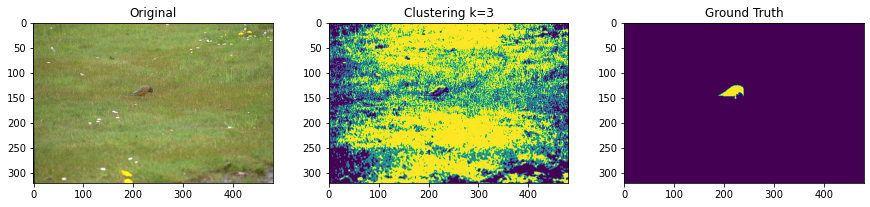

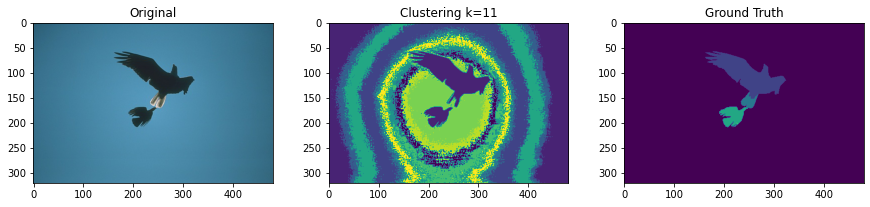

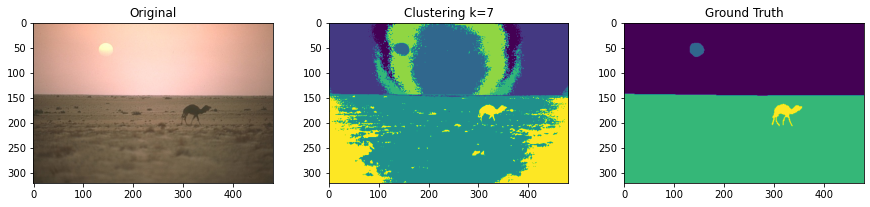

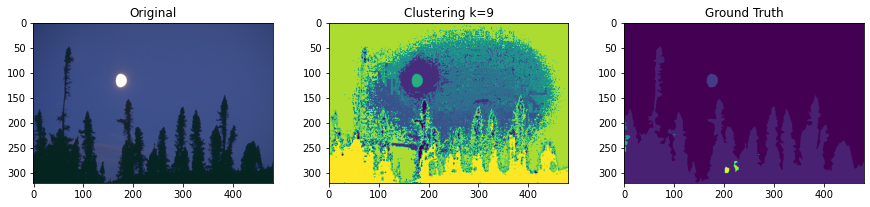

In [21]:
# Good example
for i in range(4):
    img_index = sorted_scores[-(i+1)]
    img_k = np.argmax(f_measure_average_per_k[img_index]) * 2 + 3
    clustering_path = f'output/{get_img_name(images_paths[img_index])}_{img_k}.png'

    plt.figure(figsize=(15, 10))
    plt.subplot(331)
    plt.title('Original')
    plt.imshow(images[img_index])
    plt.subplot(332)
    plt.title(f'Clustering k={img_k}')
    plt.imshow(imread(clustering_path))
    plt.subplot(333)
    plt.title('Ground Truth')
    plt.imshow(gts[img_index][0])
    plt.show()

# K-means: Spatial Clustering
We incorporated pixels spatial coordinates in the feature vector. In addition

0.9492564563405926


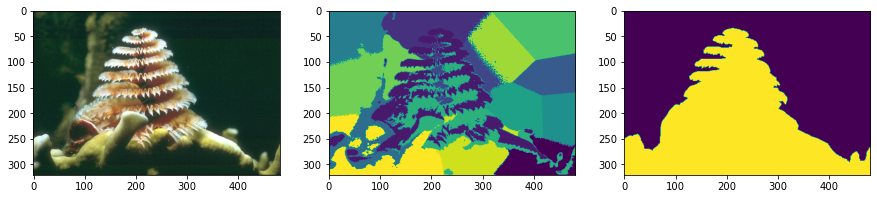

In [12]:
img_prev = images[20]
# img = rescale_intensity(rgb2hsv(img))
# print(img.max())
labels = my_kmeans(img_prev, 15, use_space=True)

plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(img_prev)
plt.subplot(132)
plt.imshow(labels)
plt.subplot(133)
plt.imshow(gts[20][0])
print(get_f_measure(labels.reshape(-1), gts[20][0].reshape(-1)))

In [22]:
def knn_dist(d, k):
    dist_mat = np.linalg.norm(d[:, None, ...] - d, axis=2)
    nearset_mat = np.zeros_like(dist_mat)
    inds = np.argpartition(dist_mat, k+1, axis=1)[:, :k+1]
    nearset_mat[np.arange(len(dist_mat)).reshape(-1, 1), inds] = 1
    np.fill_diagonal(nearset_mat, 0)
    return nearset_mat

In [23]:
def image_normalized_cut(img, k, use_distance=False):
    superpixels = slic(img)
    output_seg = np.zeros_like(superpixels)

    if use_distance:
        x = np.linspace(0, 1, img.shape[0])
        y = np.linspace(0, 1, img.shape[1])
        xx, yy = np.meshgrid(x, y, indexing='ij')
        features = np.dstack((img, xx, yy))
    else:
        features = img

    superpixels_labels = np.unique(superpixels)

    vertices = np.array([np.mean(features[superpixels == label], axis=0) for label in superpixels_labels])
    similarity_matrix = knn_dist(vertices, k)
    clustering = spectral_clustering(similarity_matrix, n_clusters=k)

    for label, value in zip(superpixels_labels, clustering):
        output_seg[superpixels == label] = value
    
    return output_seg

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)
C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


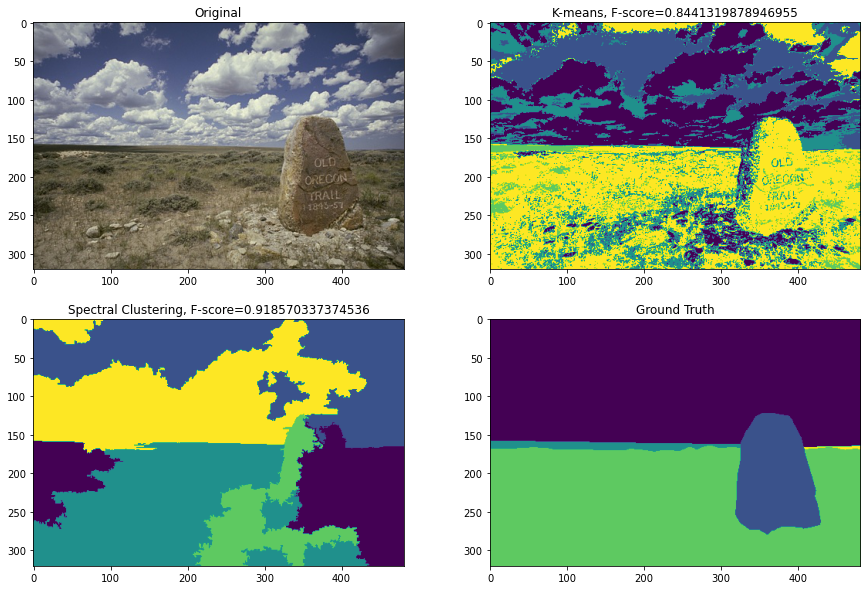

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


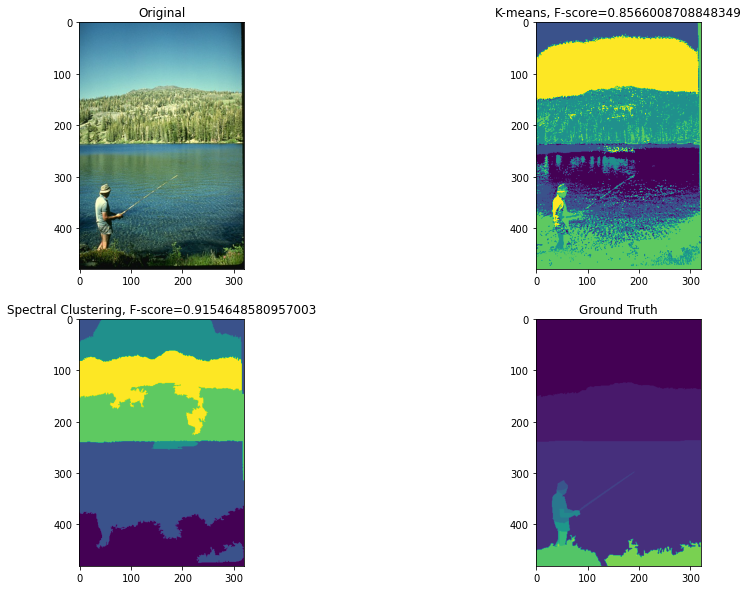

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


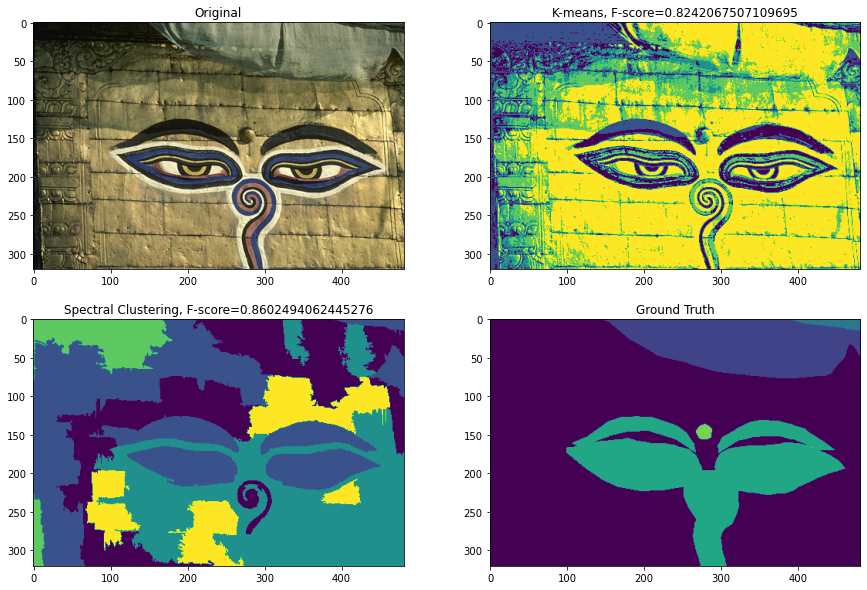

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


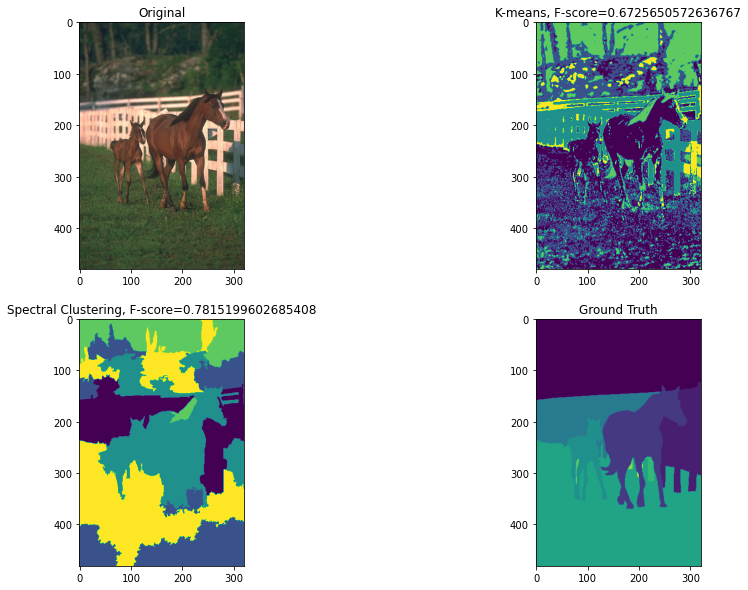

C:\Users\ahmed\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


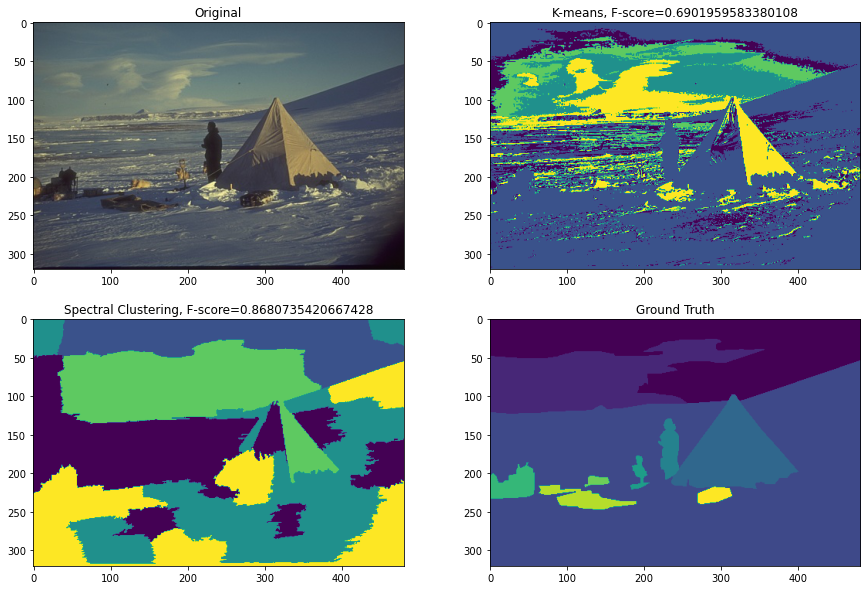

In [26]:
image_set_indices = np.random.choice(len(images), 5, False)
image_set = [images[i] for i in image_set_indices]
gt_set = [gts[i][0] for i in image_set_indices]

for img, gt in zip(image_set, gt_set):
    labels_kmeans = my_kmeans(img, 5)
    labels_spectral = image_normalized_cut(img, 5)

    kmeans_f_score = get_f_measure(labels_kmeans.reshape(-1), gt.reshape(-1))
    spectral_f_score = get_f_measure(labels_spectral.reshape(-1), gt.reshape(-1))

    plt.figure(figsize=(15, 10))
    plt
    plt.subplot(221)
    plt.title('Original')
    plt.imshow(img)
    plt.subplot(222)
    plt.title(f'K-means, F-score={kmeans_f_score}')
    plt.imshow(labels_kmeans)
    plt.subplot(223)
    plt.title(f'Spectral Clustering, F-score={spectral_f_score}')
    plt.imshow(labels_spectral)
    plt.subplot(224)
    plt.title('Ground Truth')
    plt.imshow(gt)
    plt.show()

In [ ]:
n_cut = image_normalized_cut(images[0], 9, False)

print(get_f_measure(n_cut.reshape(-1), gts[6][0].reshape(-1)))

plt.figure(figsize=(15, 10))
plt.subplot(331)
plt.imshow(images[6])
plt.subplot(332)
plt.imshow(n_cut)
plt.subplot(333)
plt.imshow(gts[6][0])
plt.show()